# Train

In [74]:
import numpy as np
import pandas as pd 
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import keras
import sys

# Import architectures
from keras.applications import xception

from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as im
import time
import datetime

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

In [75]:
# Train phase

tf.keras.backend.set_learning_phase(1) 

In [76]:
# Choose GPU

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [77]:
now = datetime.datetime.now()
timeset = now.strftime("%d-%m-%Y_%H:%M")


# 1) Path to train and test datasets
train_dir = "/home/linnik/Datasets/Traffic_lights/Union_new/train/"   
test_dir = "/home/linnik/Datasets/Traffic_lights/Union_new/test/"


# 2) Target width and height of input images, number of classes, number of train and test images, batch size, epochs
img_height, img_width = 96, 32
n_classes = len(os.listdir(train_dir))
nb_train_samples = sum([len(os.listdir(train_dir + folder)) for folder in os.listdir(train_dir)])
nb_test_samples = sum([len(os.listdir(test_dir + folder)) for folder in os.listdir(test_dir)])
batch_size = 128
epochs = 1


# 3) Name of file where will be saved trained model
# model_name = ".../Architecture_InputShape_NClasses_date_time.hdf5"
model_name = "/home/linnik/Nets/My_Model.hdf5"


# 4) Compile parametrs
loss_ = 'categorical_crossentropy'
optimizer_ = 'adam'
metrics_ = ['acc']


# 5) Classes name
classes_names = {0: "NA", 1: "R", 2: "Y", 3: "G"}


# 6) Logs for confedence on test data 
# csv_path = ".../Architecture_InputShape_NClasses_date_time_ConfedenceLog.csv"
csv_path = "/home/linnik/Nets/Confedence_Logs/My_Model_96x32x3_4_" + timeset + "_ConfedenceLog.csv"


# 7) General logs of the model
# log_path = ".../Architecture_InputShape_NClasses_date_time_GeneralLog.txt"
log_path = "/home/linnik/Nets/General_Logs/My_Model_96x32x3_4_" + timeset + "_GeneralLog.txt"

In [78]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    zoom_range = 0.2,
    rotation_range = 5,
    width_shift_range = img_width // 3,
    height_shift_range = img_height // 3,
    horizontal_flip = True,
    vertical_flip = False)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [79]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 24755 images belonging to 4 classes.
Found 5066 images belonging to 4 classes.


[0. 0. 0. 1.]
(96, 32, 3)


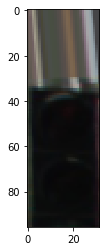

In [80]:
# Check size

for x, y in train_generator:
    plt.imshow(x[0])
    print(y[0])
    print(x[0].shape)
    break

In [81]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def resNetM(input_shape, classes):
    img_input = Input(shape=input_shape)

    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = AveragePooling2D((3, 3), name='avg_pool')(x)

    x = Flatten()(x)
    #x = Dense(512, activation='relu', name='fc01')(x)
    #x = Dense(200, activation='relu', name='fc02')(x)
    #x = Dropout(0.3, name='dr01')(x)
    x = Dense(classes, activation='softmax', name='fc5')(x)

    inputs = img_input

    model = Model(inputs, x, name='resnetM')

    return model

In [15]:
# Create and compile your own model

model = resNetM((img_height, img_width, 3), n_classes)
model.compile(loss = loss_, optimizer = optimizer_, metrics = metrics_)

In [13]:
# Create and compile Keras model

img_height, img_width = 71, 71 # cause input size for Xception model must be at least 71x71


# So we need to change our generators too
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')


def build_model_Xception():
    base_model = xception.Xception(include_top = True, 
                                      weights = None,
                                      input_tensor = None,
                                      input_shape = (img_height, img_width, 3),
                                      pooling = None,
                                      classes = n_classes)
  
    for layer in base_model.layers:
        layer.trainable = True
      
    model = Model(inputs = base_model.input, outputs = base_model.output)
    return model


model = build_model_Xception()
model.compile(loss = loss_, optimizer = optimizer_, metrics = metrics_)

Found 24755 images belonging to 4 classes.
Found 5066 images belonging to 4 classes.


In [16]:
# Callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, min_delta = 1e-4)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)
check = ModelCheckpoint(filepath = model_name, monitor = "val_acc", save_best_only = True)

callbacks_list = [early_stop, reduce_lr, check]

In [17]:
%%time

# Train model

model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

Epoch 1/1
193/193 [==============================] - 43s 225ms/step - loss: 0.5731 - acc: 0.8054 - val_loss: 0.4851 - val_acc: 0.8528
CPU times: user 56.1 s, sys: 3.11 s, total: 59.2 s
Wall time: 1min


# Test

In [82]:
# Test phase

tf.keras.backend.set_learning_phase(0)

In [83]:
# Load trained model

loaded_model = load_model(model_name)

In [84]:
# Speed test using generator

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = 'categorical')

nb_samples = len(test_generator.filenames)

start_time = time.time()
predict = loaded_model.predict_generator(test_generator, steps = nb_samples)
print("Average time to pridict one photo using generator is", (time.time() - start_time)/nb_samples)

Found 5066 images belonging to 4 classes.
Average time to pridict one photo using generator is 0.005789668579794322


In [85]:
def Precision_Recall_metrics(test_dir, model):
    n_classes = len(os.listdir(test_dir))
    
    right = 0
    wrong = 0
    times = []

    TP = [0 for i in range(n_classes)]
    FN = [0 for i in range(n_classes)]
    FP = [0 for i in range(n_classes)]
    precision = [0 for i in range(n_classes)]
    recall = [0 for i in range(n_classes)]

    for folder in os.listdir(test_dir):
        for img in os.listdir(test_dir + "/" + folder):
            imag = im.load_img(test_dir + "/" + folder + "/" + img, target_size = (img_height, img_width))

            photo_ar = im.img_to_array(imag)
            photo_ar = np.expand_dims(photo_ar, axis = 0)
            photo_ar /= 255

            start_time = time.time()
            ans = np.argmax(model.predict(photo_ar))
            times.append(time.time() - start_time)

            if ans == int(folder):
                right += 1
            else:
                wrong += 1


            if ans == int(folder):
                TP[ans] += 1
            if ans != int(folder):
                FN[ans] += 1
                FP[int(folder)] += 1


    for i in range(n_classes):
        try:
            precision[i] = TP[i]/(TP[i] + FP[i])
        except:
            precision[i] = 0

        try:
            recall[i] = TP[i]/(TP[i] + FN[i])
        except:
            recall[i] = 0
    precision = np.array(precision)
    recall = np.array(recall)
    
    accuracy = right/(right + wrong)
    avr_time = np.array(times).mean()
    
    return accuracy, avr_time, precision, recall

In [86]:
%%time

accuracy, avr_time, precision, recall = Precision_Recall_metrics(test_dir, loaded_model)
            

print("Accuracy on test set is", accuracy)
print("Average time to pridict one photo without generator is", avr_time, "seconds")

print()

print(precision.max(), precision.min(), precision.mean())
print(recall.max(), recall.min(), recall.mean())

Accuracy on test set is 0.8523489932885906
Average time to pridict one photo without generator is 0.006440033613341249 seconds

0.9720946661956905 0.4823529411764706 0.7305245119345843
0.9575320512820513 0.4689265536723164 0.7400729325812802
CPU times: user 27.3 s, sys: 1.45 s, total: 28.7 s
Wall time: 35.5 s


<Figure size 1440x720 with 0 Axes>

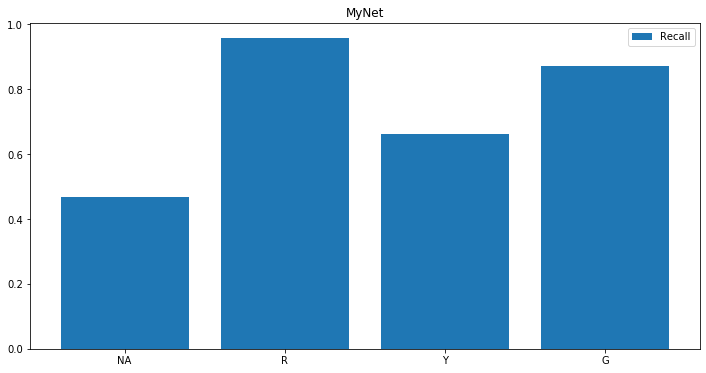

In [87]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(list(classes_names.values()), recall, label = "Recall")
plt.legend(loc = 'best')
plt.title("MyNet")

fig.set_figwidth(12)
fig.set_figheight(6)

<Figure size 1440x720 with 0 Axes>

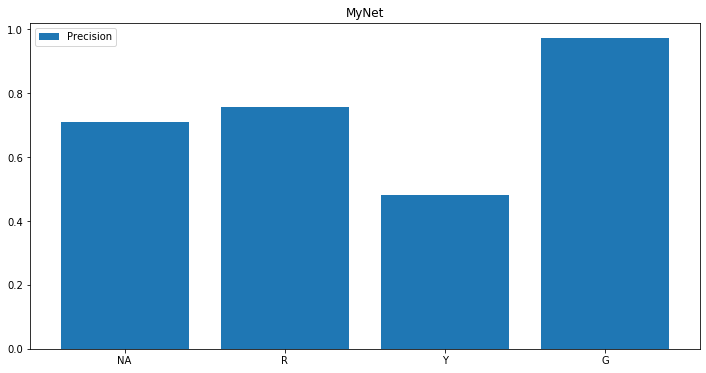

In [88]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(list(classes_names.values()), precision, label = "Precision")
plt.legend(loc = 'best')
plt.title("MyNet")


fig.set_figwidth(12)
fig.set_figheight(6)

# General Logs

In [92]:
def general_log_txt(log_path, model, model_history, prec_rec = True):
    stringlist = []
    model.summary(print_fn = lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    
    H = model_history

    with open(log_path, "w") as log:
        # Save model parametrs
        log.write('1) Model parametrs\n')
        log.write("Train_dir: " + train_dir + "\n")
        log.write("Test_dir: " + test_dir + "\n")

        log.write("Input_shape: " + str(img_height) + "x" + str(img_width) + "x" + "3" + "\n")
        log.write("Number_classes: " + str(n_classes) + "\n")
        log.write("Number_train_samples: " + str(nb_train_samples) + "\n")
        log.write("Number_test_samples: " + str(nb_test_samples) + "\n")
        log.write("Batch_size: " + str(batch_size) + "\n")
        log.write("Epochs: " + str(epochs) + "\n")

        log.write("Loss_function: " + loss_ + "\n")
        log.write("Optimizer: " + optimizer_ + "\n")
        log.write("Metrics: " + str(metrics_) + "\n")

        log.write("Classes_dictionary: " + str(classes_names) + "\n")

        log.write("Csv_path: " + csv_path + "\n")
        log.write("Log_path: " + log_path + "\n")

        # Save model summary
        log.write('\n2) Model summary\n')
        log.write(short_model_summary)
        log.write("\n")
        
        # Save model history
        log.write('\n3) Model history\n')
        log.write('Train_loss: ' + str(H.history["loss"]) + '\n')
        log.write('Test_loss: ' + str(H.history["val_loss"]) + '\n')
        log.write('Train_accuracy: ' + str(H.history["acc"]) + '\n')
        log.write('Test_accuracy: ' + str(H.history["val_acc"]) + '\n')
        
        if prec_rec:
            # Save model history
            log.write('\n4) Precision and recall:\n')
            log.write('Precision: ' + str(precision) + '\n')
            log.write('Recall: ' + str(recall) + '\n')

In [93]:
general_log_txt(log_path, model, model_history)

# Confedence Logs

In [201]:
def confedence_df(test_dir, model, classes_names, csv_path = None):
    classes = list(classes_names.values())
    col = ["Image_dir", "Tagret_class"]
    for cls in classes:
        col.append(cls)
        
    df = pd.DataFrame(columns = col)
    ind = 0
    
    for folder in os.listdir(test_dir):
        for img in os.listdir(test_dir + "/" + folder):
            imag = im.load_img(test_dir + "/" + folder + "/" + img, target_size = (img_height, img_width))

            photo_ar = im.img_to_array(imag)
            photo_ar = np.expand_dims(photo_ar, axis = 0)
            photo_ar /= 255

            ans = np.round(loaded_model.predict(photo_ar), 4)
            
            tar = [test_dir + "/" + folder + "/" + img, folder]
            for i in ans[0]:
                tar.append(i)

            df.loc[len(df)] = tar

    if csv_path is not None:
        df.to_csv(csv_path)
            
    return df

In [204]:
df = confedence_df(test_dir, model, classes_names, csv_path)
df

,Image_dir,Tagret_class,NA,R,Y,G
0,/home/linnik/Datasets/Traffic_lights/Union_new...,3,0.0001,0.0009,0.0004,0.9985
1,/home/linnik/Datasets/Traffic_lights/Union_new...,0,0.9014,0.0555,0.0143,0.0288
2,/home/linnik/Datasets/Traffic_lights/Union_new...,2,0.0001,0.0532,0.9464,0.0002
3,/home/linnik/Datasets/Traffic_lights/Union_new...,1,0.0000,1.0000,0.0000,0.0000


# Converter

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model

from keras.models import *
from keras.layers import *
from keras.optimizers import *



save_pb_dir = '/home/linnik/Nets/models'

def freeze_graph(graph, session, output, save_pb_dir = '.', save_pb_name = 'frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen


# This line must be executed before loading Keras model.


model = loaded_model


session = tf.keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)


input_names = [t.op.name for t in model.inputs]
output_names = [t.op.name for t in model.outputs]

# Prints input and output nodes names, take notes of them.
print(input_names, output_names)

frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], save_pb_dir = save_pb_dir, save_pb_name = 'frozen_model_ct2_Xception_TL_71x71x3.pb')